In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import gc
from collections import Counter
import pandas as pd
import glob, os, re
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import torch
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist, squareform
from tcnAutoencoder import TCNAutoencoder


In [2]:
def prep_data(df) -> pd.DataFrame:
    df = df[['Price', 'Size']]
    df.head()

    # sample every 100ms, and the size would be the sum of the size in that 100ms. 
    # Price would be the average price in that 100ms.
    df = df.resample('100ms').agg({'Price': 'mean', 'Size': 'sum'})

    # Check for NaN values

    # forwardfill all NaN values in the data
    df = df.ffill()

    # normalize the data with mean and std
    mean = df['Price'].mean()
    std = df['Price'].std()
    df['Price'] = (df['Price'] - mean) / std

    mean = df['Size'].mean()
    std = df['Size'].std()
    df['Size'] = (df['Size'] - mean) / std

    print("original shape: ", df.shape)
    
    idxs = df.index
    df = df.values

    # Create a tensor for every 30 minutes of data
    tensors = []
    tensors_timerange = []
    for i in range(0, len(df), 6000):
        if i + 18000 <= len(df):
            # flip the first and second dimension, so that the shape is (batch_size, channel, sequence_length)
            tensors.append(torch.tensor(df[i:i+18000], dtype = torch.float32).unsqueeze(0))
            tensors_timerange.append(idxs[i])
        # if it's less than 30 minutes, then we just ignore it. 
        
    del df
    gc.collect()
    
    print(f"{len(tensors)} tensor(s) created.")
            
    return tensors, tensors_timerange

    # Create the final torch tensor, every 1 hour is a sequence

tensors_list = []
tensors_timerange_list = []

In [3]:
# Read the data only once.  It's big!
csv_files = glob.glob(os.path.join(".", "data", "hft_data", "AAPL", "*_message_*.csv"))
date_str = re.compile(r'_(\d{4}-\d{2}-\d{2})_')
stock_str = re.compile(r'([A-Z]+)_\d{4}-\d{2}-\d{2}_')

df_list = []
day_list = []
sym_list = []

for csv_file in sorted(csv_files):
    date = date_str.search(csv_file)
    date = date.group(1)
    day_list.append(date)

    symbol = stock_str.search(csv_file)
    symbol = symbol.group(1)
    sym_list.append(symbol)

    # Find the order book file that matches this message file.
    book_file = csv_file.replace("message", "orderbook")

    # Read the message file and index by timestamp.
    df = pd.read_csv(csv_file, names=['Time','EventType','OrderID','Size','Price','Direction'])
    df['Time'] = pd.to_datetime(date) + pd.to_timedelta(df['Time'], unit='s')

    # Read the order book file and merge it with the messages.
    names = [f"{x}{i}" for i in range(1,11) for x in ["AP","AS","BP","BS"]]
    df = df.join(pd.read_csv(book_file, names=names), how='inner')
    df = df.set_index(['Time'])

    BBID_COL = df.columns.get_loc("BP1")
    BASK_COL = df.columns.get_loc("AP1")

    print (f"Read {df.shape[0]} unique order book shapshots from {csv_file}")
    
    tensors, timerange = prep_data(df)
    tensors_list.extend(tensors)
    tensors_timerange_list.extend(timerange)

days = len(day_list)



Read 738034 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-01_34200000_57600000_message_10.csv
original shape:  (71999, 2)
9 tensor(s) created.
Read 1923409 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-04_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 2108353 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-05_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 2364167 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-06_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 1732063 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-07_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.
Read 3123866 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-08_34200000_57600000_message_10.csv
original shape:  (234000, 2)
37 tensor(s) created.


In [4]:
# filp the first and second dimension, so that the shape is (batch_size, channel, sequence_length)
tensors_list = [tensor.permute(0, 2, 1) for tensor in tensors_list]

print(f"{len(tensors_list) = }")

dims = [tensor.shape[1] for tensor in tensors_list]


# check if all dims are the same
print(all(x == dims[0] for x in dims))

#stack tensors list together for clustering
TR_tensors = torch.cat(tensors_list, dim = 0)



len(tensors_list) = 194
True


Flattening the Tensors: Convert each tensor into a one-dimensional vector.


In [5]:
flattened_tensors = [t.flatten() for t in TR_tensors]
#check datatype
flattened_tensors

# convert to numpy
flattened_tensors = [t.numpy() for t in flattened_tensors]
_ = [print(f"{flattened_tensors[i].shape = }") for i in range(len(flattened_tensors))]

flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_tensors[i].shape = (36000,)
flattened_te

Distance Calculation: Compute the distance between each pair of vectors. 

In [6]:
e_distance_matrix = squareform(pdist(flattened_tensors, 'euclidean'))
m_distance_matrix = squareform(pdist(flattened_tensors, 'cityblock'))
c_distance_matrix = squareform(pdist(flattened_tensors, 'cosine'))


Hierarchical Clustering Algorithm:

In [7]:
Z_e_centroid = linkage(e_distance_matrix, 'centroid')
Z_m_centroid = linkage(m_distance_matrix, 'centroid')
Z_c_centroid = linkage(c_distance_matrix, 'centroid')


/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1519762082.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_e_centroid = linkage(e_distance_matrix, 'centroid')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1519762082.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_m_centroid = linkage(m_distance_matrix, 'centroid')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1519762082.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_c_centroid = linkage(c_distance_matrix, 'centroid')


In [8]:
Z_e_single = linkage(e_distance_matrix, 'single')
Z_m_single = linkage(m_distance_matrix, 'single')
Z_c_single = linkage(c_distance_matrix, 'single')


/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/323641117.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_e_single = linkage(e_distance_matrix, 'single')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/323641117.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_m_single = linkage(m_distance_matrix, 'single')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/323641117.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_c_single = linkage(c_distance_matrix, 'single')


In [9]:
Z_e_complete = linkage(e_distance_matrix, 'complete')
Z_m_complete = linkage(m_distance_matrix, 'complete')
Z_c_complete = linkage(c_distance_matrix, 'complete')


/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1136515034.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_e_complete = linkage(e_distance_matrix, 'complete')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1136515034.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_m_complete = linkage(m_distance_matrix, 'complete')
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_30791/1136515034.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_c_complete = linkage(c_distance_matrix, 'complete')


Cluster Formation:
Cut the dendrogram at the desired level to form clusters.


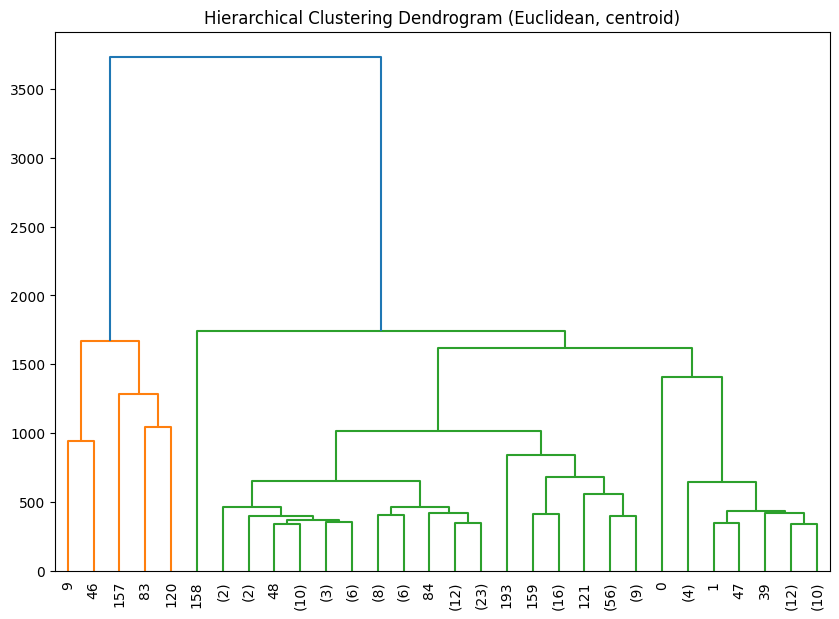

In [10]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    Z_e_centroid,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
)

plt.title('Hierarchical Clustering Dendrogram (Euclidean, centroid)')
plt.show()


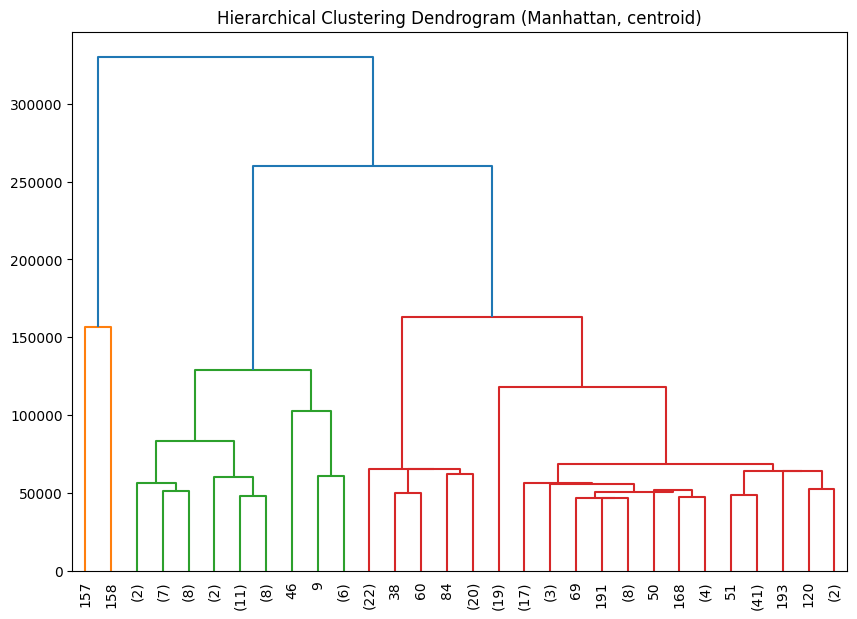

In [11]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    Z_m_centroid,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Manhattan, centroid)')
plt.show()

In [12]:
tensors_timerange_list[157]

Timestamp('2024-03-08 09:30:00')

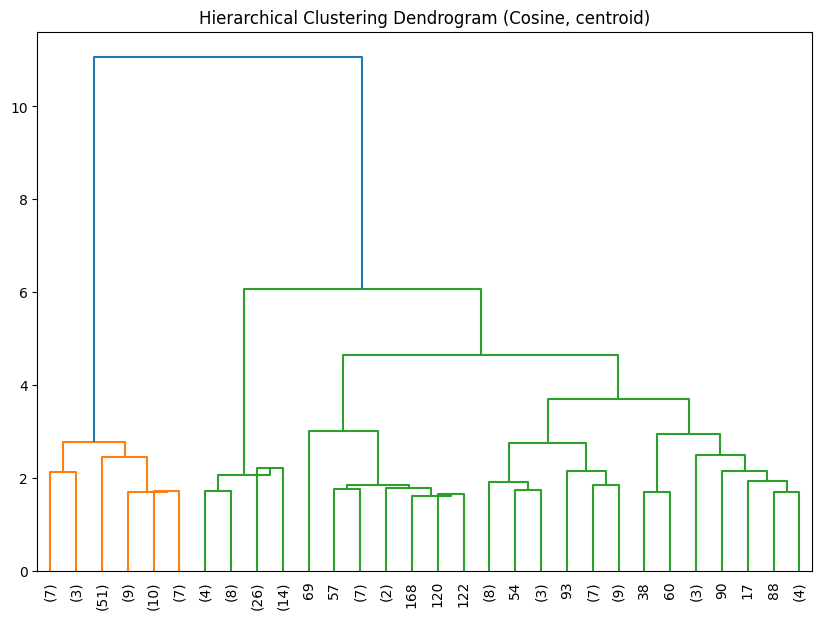

In [13]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_c_centroid,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Cosine, centroid)')
plt.show()

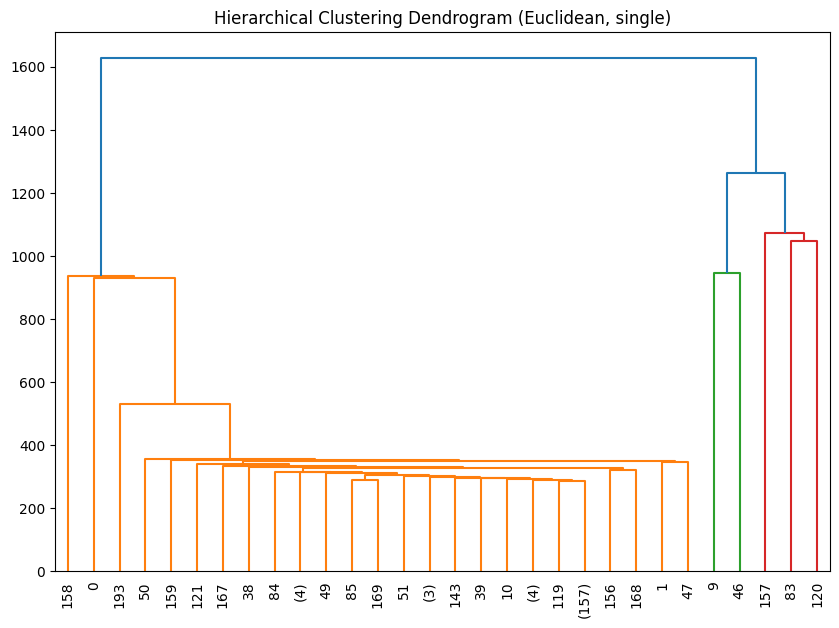

In [14]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_e_single,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
    
)
plt.title('Hierarchical Clustering Dendrogram (Euclidean, single)')
plt.show()

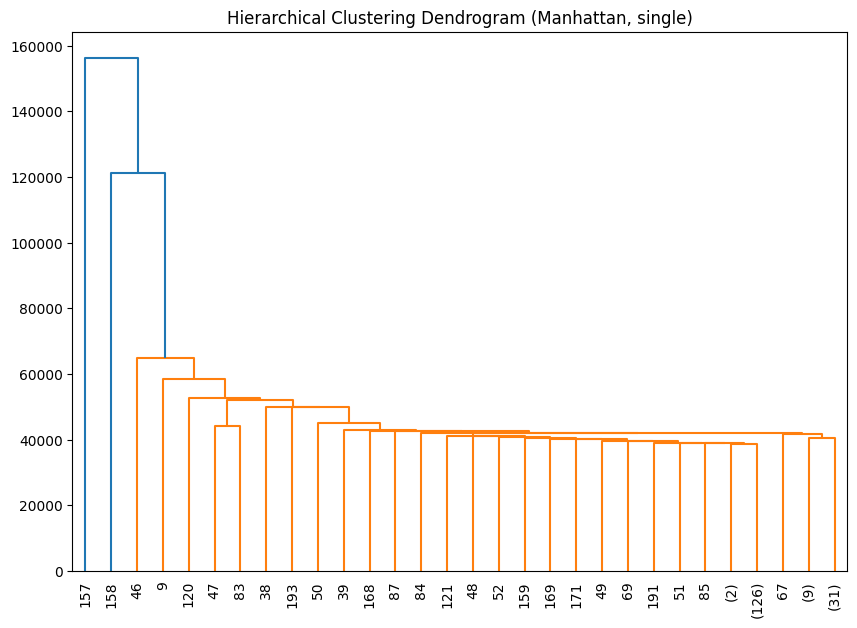

In [15]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_m_single,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Manhattan, single)')
plt.show()

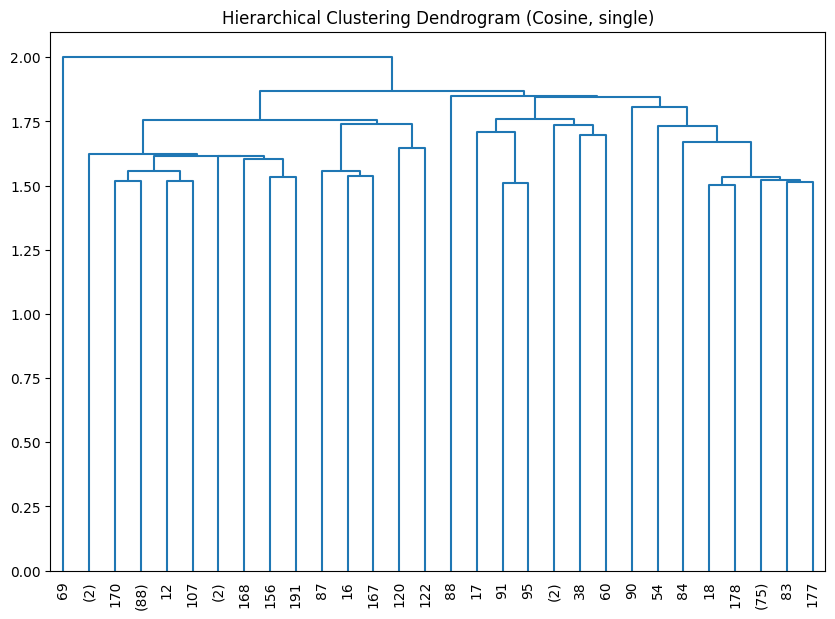

In [16]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_c_single,
    truncate_mode='lastp',  
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Cosine, single)')
plt.show()

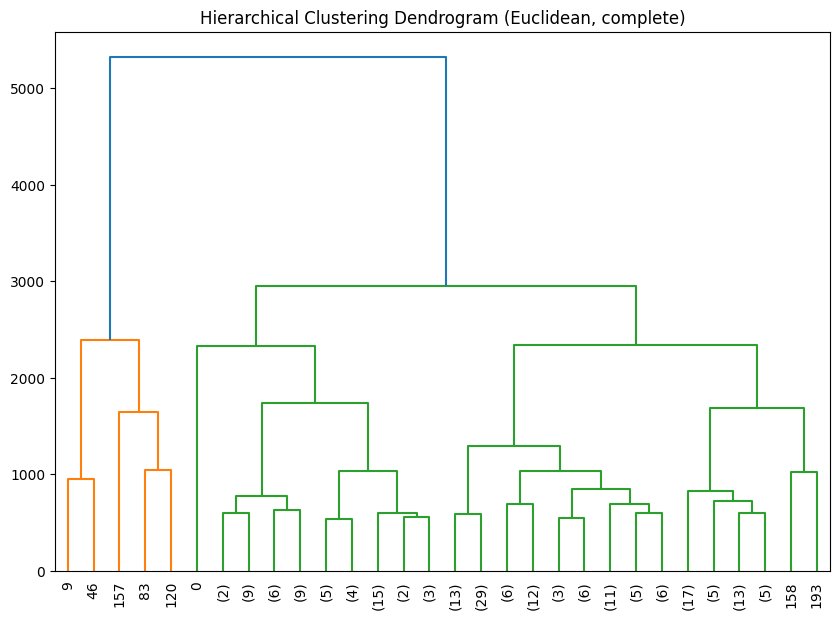

In [17]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_e_complete,
    truncate_mode='lastp',   
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Euclidean, complete)')
plt.show()

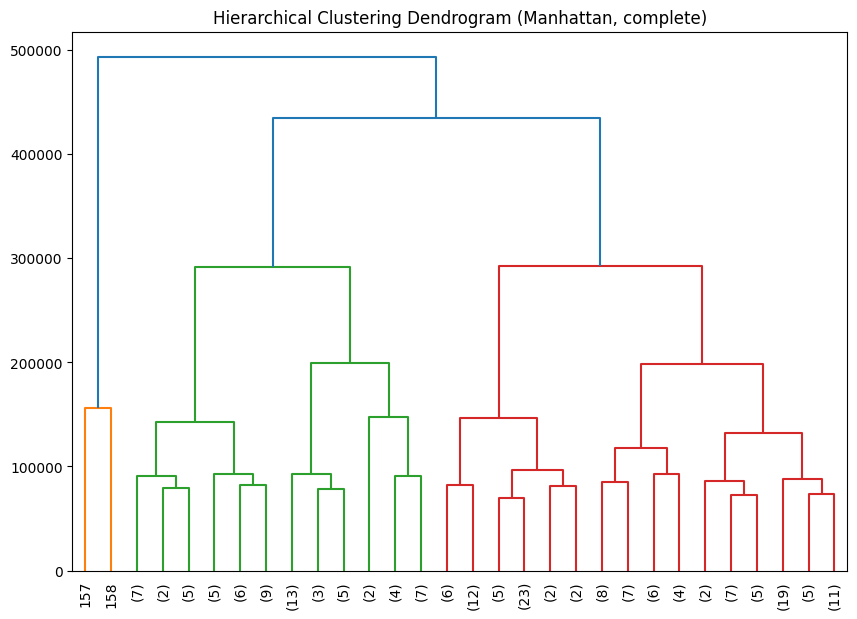

In [18]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_m_complete,
    truncate_mode='lastp',   
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Manhattan, complete)')
plt.show()

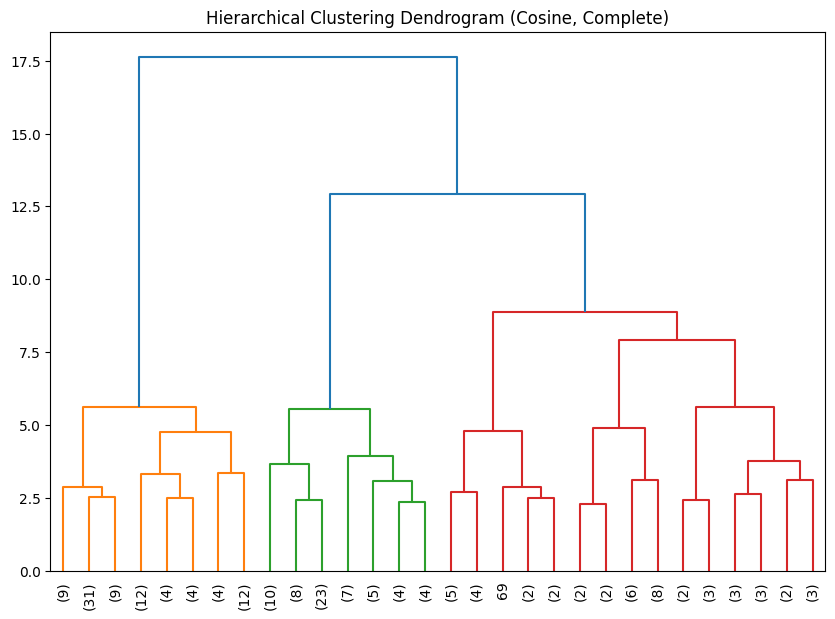

In [19]:
plt.figure(figsize=(10, 7))
dendrogram(
    Z_c_complete,
    truncate_mode='lastp',   
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Hierarchical Clustering Dendrogram (Cosine, Complete)')
plt.show()

In [20]:
tensors_timerange_list[157]
tensors_timerange_list[158]

Timestamp('2024-03-08 09:40:00')

In [21]:
_ = [print(f"{tensors_timerange_list[i] = }") for i in range(len(tensors_timerange_list))]

tensors_timerange_list[i] = Timestamp('2024-03-01 09:30:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 09:40:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 09:50:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:00:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:10:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:20:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:30:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:40:00')
tensors_timerange_list[i] = Timestamp('2024-03-01 10:50:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 09:30:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 09:40:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 09:50:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 10:00:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 10:10:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 10:20:00')
tensors_timerange_list[i] = Timestamp('2024-03-04 10:30:00')
tensors_timerange_list[i